# FlowSOM Clustering

In this tutorial we are going to review how you can use FlowSOM to cluster single cell cytometry data. To demonstrate the FlowSOM algorithm we will be using the Levine 32 dimensional mass cytometry data originally introduced in the Phenograph paper "Data-Driven Phenotypic Dissection of AML Reveals Progenitor-like Cells that Correlate with Prognosis" in 2015 (https://pubmed.ncbi.nlm.nih.gov/26095251/). You can obtain the Levine data from this GitHub repository: https://github.com/lmweber/benchmark-data-Levine-32-dim/tree/master/data.

In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import pytometry as pm


sc.logging.print_versions()
sc.settings.verbosity = 3

-----
anndata     0.9.2
scanpy      1.9.5
-----
PIL                         10.0.1
anyio                       NA
argcomplete                 NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.0
backcall                    0.2.0
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.0
cloudpickle                 2.2.1
comm                        0.1.4
consensusclustering         NA
cycler                      0.12.0
cython_runtime              NA
dask                        2023.9.3
datashader                  0.15.2
datashape                   0.5.2
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
exceptiongroup              1.1.3
executing                   2.0.0
fastjsonschema              NA
fcspa

First we will load the data.

In [3]:
adata = pm.io.read_fcs("./Levine_32dim_notransform.fcs")

In [4]:
adata.var

,n,channel,marker,$PnB,$PnE,$PnR
Time,1,Time,,32,"0,0",1024
Cell_length,2,Cell_length,,32,"0,0",1024
DNA1,3,DNA1,,32,"0,0",1024
DNA2,4,DNA2,,32,"0,0",1024
CD45RA,5,CD45RA,,32,"0,0",1024
CD133,6,CD133,,32,"0,0",1024
CD19,7,CD19,,32,"0,0",1024
CD22,8,CD22,,32,"0,0",1024
CD11b,9,CD11b,,32,"0,0",1024
CD4,10,CD4,,32,"0,0",1024


As you can see, the dataset consists of numerous channels and some meta-variables such as individual and label.

In [5]:
adata[:, "label"].to_df()["label"].value_counts(dropna=False)

NaN     161443
7.0      26366
10.0     21099
8.0      20108
9.0      16520
13.0      6135
2.0       3905
4.0       3295
3.0       2248
11.0      1238
1.0       1207
6.0        916
14.0       513
12.0       330
5.0        304
Name: label, dtype: int64

In [6]:
adata[:, "individual"].to_df()["individual"].value_counts(dropna=False)

1.0    191351
2.0     74276
Name: individual, dtype: int64

In [7]:
channels = [
    "DNA1",
    "DNA2",
    "CD45RA",
    "CD133",
    "CD19",
    "CD22",
    "CD11b",
    "CD4",
    "CD8",
    "CD34",
    "Flt3",
    "CD20",
    "CXCR4",
    "CD235ab",
    "CD45",
    "CD123",
    "CD321",
    "CD14",
    "CD33",
    "CD47",
    "CD11c",
    "CD7",
    "CD15",
    "CD16",
    "CD44",
    "CD38",
    "CD13",
    "CD3",
    "CD61",
    "CD117",
    "CD49d",
    "HLA-DR",
    "CD64",
    "CD41",
]

We want to normalise the channels with a hyperbolic inverse sine with cofactor 5 (as performed in the original paper)

In [8]:
adata_arcsinh = pm.tl.normalize_arcsinh(adata[:, channels], cofactor=5, inplace=False)

We can now cluster our data with the `flowsom_clustering` function from the `tl` (tools) module of `pytometry`. The FlowSOM algorithm works in the following stages:
1. A self-organising map is trained that learns a low dimensional embedding of the single cell feature space
2. Consensus clustering (https://github.com/burtonrj/consensusclustering) of the SOM nodes identifies the optimal number of clusters to retain
3. Each observation is assigned to a cluster according to its nearest meta-cluster in the SOM

The function is going to take as input:
* `adata` - our annotated dataframe of normalised channels
* `key_added` - the key to add the cluster labels under
* `som_dim` - the size of the self-organising map; (10, 10) is the default size used by the original FlowSOM implementation and usually does not need to be altered
* `sigma` - this controls the radius of the neighbourhood function and again the default value of 1.0 works well in most cases
* `learning_rate` - controls the size of weight vector in learning of SOM and the default value of 0.5 works well in most cases
* `batch_size` - adjust if you have memory constraints 
* `seed` - random seed for reproducibility
* `min_clusters` - the minimum number of clusters when searching for the optimal number of clusters in consensus clustering
* `max_clusters` - the maximum number of clusters when searching for the optimal number of clusters in consensus clustering
* `return_clustering_objs` - if True, the SOM and Consensus Clustering objects are returned; this can be helpful for inspecting the results as shown later
* `verbose` - show progress bars etc
* `copy` - copy the `adata` object (recommended)
* `agglomerative_clustering_kwargs` - keyword arguments passed to the `AgglomerativeClustering` Scikit-Learn object used by the consensus clustering

In [9]:
adata_flowsom, cluster_objs = pm.tl.flowsom_clustering(
    adata=adata_arcsinh,
    key_added="flowsom_clusters",
    som_dim=(10, 10),
    sigma=1.0,
    learning_rate=0.5,
    batch_size=500,
    seed=42,
    min_clusters=10,
    max_clusters=20,
    return_clustering_objs=True,
    verbose=True,
    inplace=True,
    agglomerative_clustering_kwargs={"metric": "euclidean", "linkage": "ward"},
)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 3.422194930315085


Computing consensus matrices:   0%|          | 0/11 [00:00<?, ?it/s]

Assigning cluster labels to cells:   0%|          | 0/265627 [00:00<?, ?it/s]

In [10]:
adata_flowsom.obs["flowsom_clusters"].value_counts()

cluster_6     50159
cluster_7     41397
cluster_2     34354
cluster_3     31562
cluster_0     23688
cluster_10    19259
cluster_14    17600
cluster_8     10731
cluster_9     10146
cluster_1      9226
cluster_4      6871
cluster_12     4179
cluster_11     3970
cluster_5      1406
cluster_13     1079
Name: flowsom_clusters, dtype: int64

FlowSOM has generated 15 clusters. Lets visualise them using PCA and UMAP:

computing PCA
    with n_comps=33
    finished (0:00:00)


/home/ross/Projects/pytometry/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


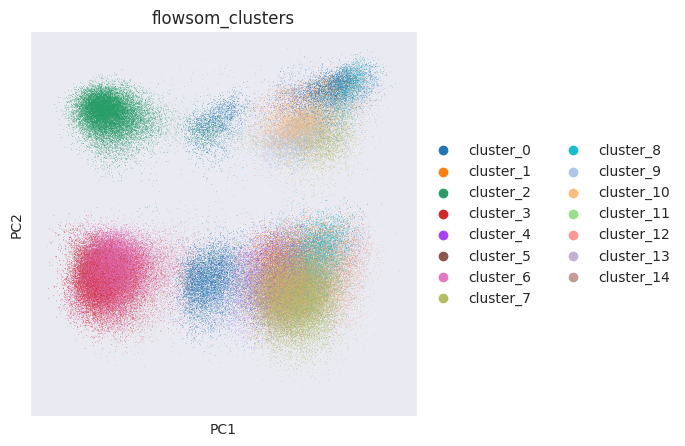

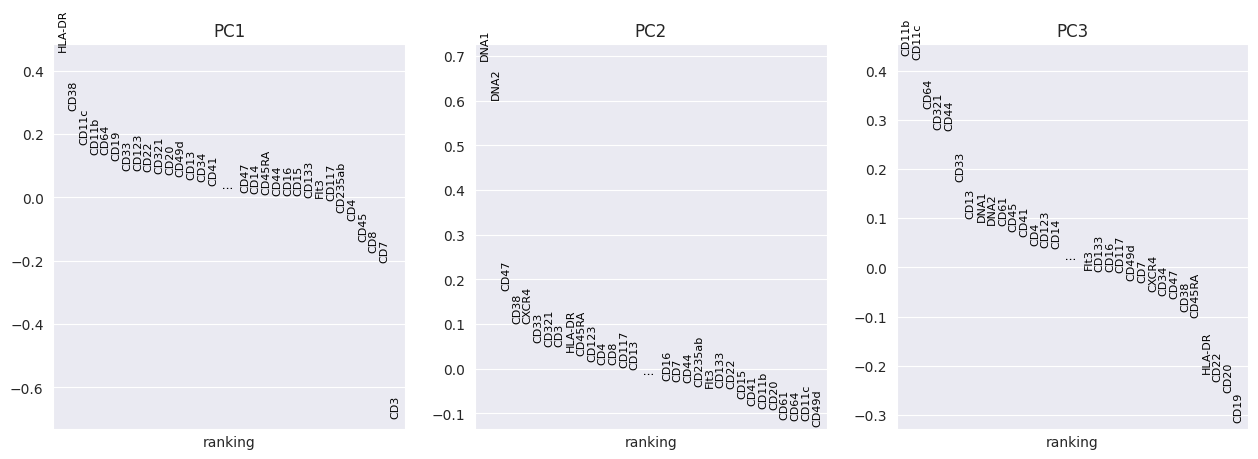

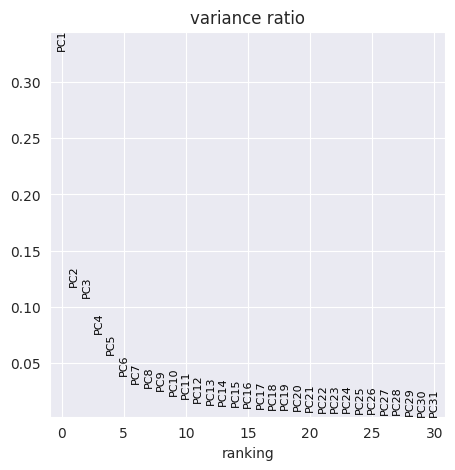

In [11]:
sc.pp.pca(adata_flowsom)
pl.rcParams["figure.figsize"] = (5, 5)
sc.pl.pca_overview(
    adata_flowsom,
    color="flowsom_clusters",
)

In [12]:
sc.pp.pca(adata_flowsom, n_comps=10)
sc.pp.neighbors(adata_flowsom, n_neighbors=15, use_rep="X_pca")

computing PCA
    with n_comps=10
    finished (0:00:00)
computing neighbors


/home/ross/Projects/pytometry/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)


In [13]:
sc.tl.umap(adata_flowsom)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:50)


/home/ross/Projects/pytometry/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


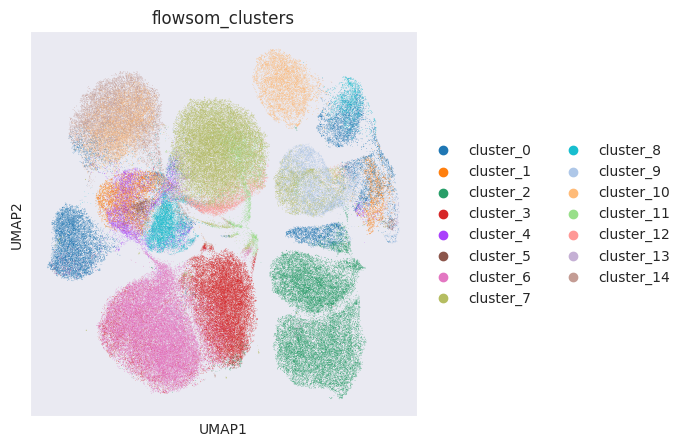

In [14]:
sc.pl.umap(adata_flowsom, color="flowsom_clusters")

We can inspect why 15 clusters were chosen by accessing the `ConsensusClustering` object returned by the our FlowSOM function. Consensus clustering works by calculating the consensus matrix of observations across random resamples of our data - stable clustering should result in observations consistently existing within the same or different clusters, if they sometimes appear in the same cluster or sometime do not, this suggests the clustering is unstable.

We can plot the CDF of the consensus matrix across different `k` clusters and observe the change point at which the area under the CDF no longer increased with the same magnitude. The plots below show the change point as detected by consensus clustering (first plot) and the CDF for each value of `k` (second plot).

<Axes: xlabel='K', ylabel='Area under CDF'>

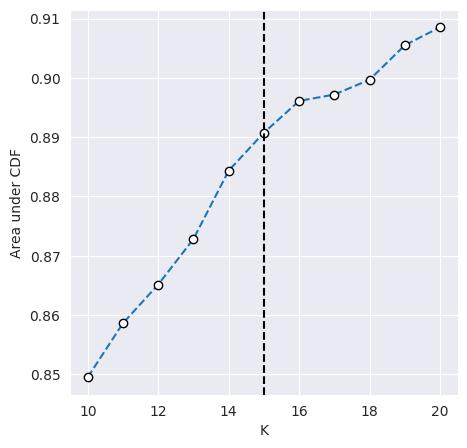

In [15]:
cluster_objs["consensus_clustering"].plot_auc_cdf()

<Axes: xlabel='Consensus index value', ylabel='CDF'>

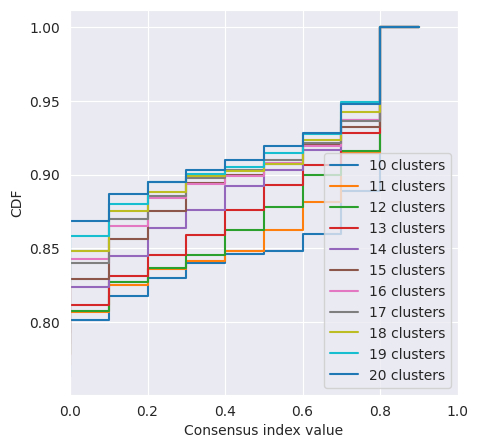

In [16]:
cluster_objs["consensus_clustering"].plot_cdf()

The change in CDF below and above a `k` of 15 is subtle and we would expect ideal clustering to have consensus index values occuring around 0 or 1, but biological data is often noisy and consensus clusters can be difficult to identify.

The consensus matrix for the chosen `k` of 15 is shown below. Notice how for many observations a clear consensus is established along the diagonal but some observations are more difficult and have a 'fuzzy' allocation across clusters.

/home/ross/Projects/pytometry/venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ross/Projects/pytometry/venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


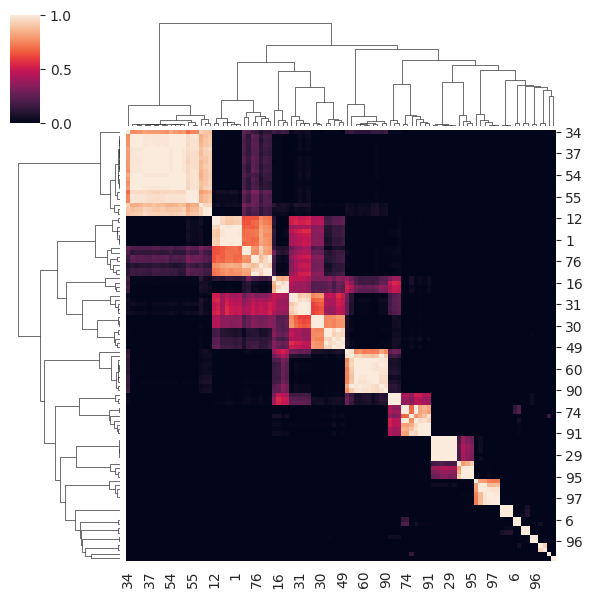

In [17]:
cluster_objs["consensus_clustering"].plot_clustermap(15, figsize=(6, 6))